In [11]:
import pandas as pd
import numpy as np
import io
import warnings
warnings.filterwarnings(action='ignore')


from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

In [5]:
data=pd.read_csv("../data/integration_b.csv",encoding="utf-8", index_col="Date")
data.head()
df=data

In [6]:
# Encoding Categorical Data (If needs)

# Economic Growth Rate
encoding_dict = {'High Growth':2, 'Moderate Growth':1, 'Low Growth':0.5, 'Negative Growth':-1}
data['Economic Growth Rate'] = data['Economic Growth Rate'].map(encoding_dict)

# Interest Rate Category
encoding_dict = {'Low':1, 'Moderate':2}
data['Interest Rate Category'] = data['Interest Rate Category'].map(encoding_dict)

# Export Price Category
encoding_dict = {'Low':1, 'Medium':1.5, 'High':2, 'Very High':2.5}
data['Export Price Category'] = data['Export Price Category'].map(encoding_dict)

data['Import Price Category'] = data['Import Price Category'].map(encoding_dict)

# Printout DataFrame After Encoding Categorical Data to Numerical
print(data.head(3))
print(data.info())

            Total Traffic Volume  Exchange Rate  Gross Domestic Product (GDP)  \
Date                                                                            
2011-01-01               5466446    1121.500000                      328096.0   
2011-01-02               5059821    1121.732258                      328096.0   
2011-01-03               5631394    1121.964516                      328096.0   

            Export growth rate  Import growth rate  \
Date                                                 
2011-01-01           44.700000           13.600000   
2011-01-02           43.775943           13.521635   
2011-01-03           42.851885           13.443269   

            Nationwide Consumer Price Index  Regular Unleaded Gasoline  \
Date                                                                     
2011-01-01                        90.448000                    1814.57   
2011-01-02                        90.397806                    1815.24   
2011-01-03                 

In [ ]:
# 한 번만 실행
#df.drop(columns='date',inplace=True)

# Drop columns with low correlation
correlation_matrix = df.corr()
target_column = 'Total Traffic Volume'  # Assuming we are predicting Total Traffic Volume
correlation_threshold = 0.1

# Get columns with correlation higher than the threshold
high_corr_columns = correlation_matrix[abs(correlation_matrix[target_column]) > correlation_threshold].index
df_high_corr = df[high_corr_columns]

# Check for missing values in the dataframe
missing_values = df_high_corr.isnull().sum()

# Drop rows with missing values
df_high_corr_clean = df_high_corr.dropna()

# Binarize the target for simplicity (you can adjust this as per your requirement)
df_high_corr_clean['Total Traffic Volume'] = pd.cut(df_high_corr_clean['Total Traffic Volume'], bins=2, labels=[0, 1])

# Prepare the dataset for the decision tree classifier
X_class = df_high_corr_clean.drop(columns=['Total Traffic Volume'])
y_class = df_high_corr_clean['Total Traffic Volume']

# Split the dataset
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(X_class, y_class, test_size=0.2, random_state=42)

## Decision Tree Classifier - Without Hyperparameter Tuning

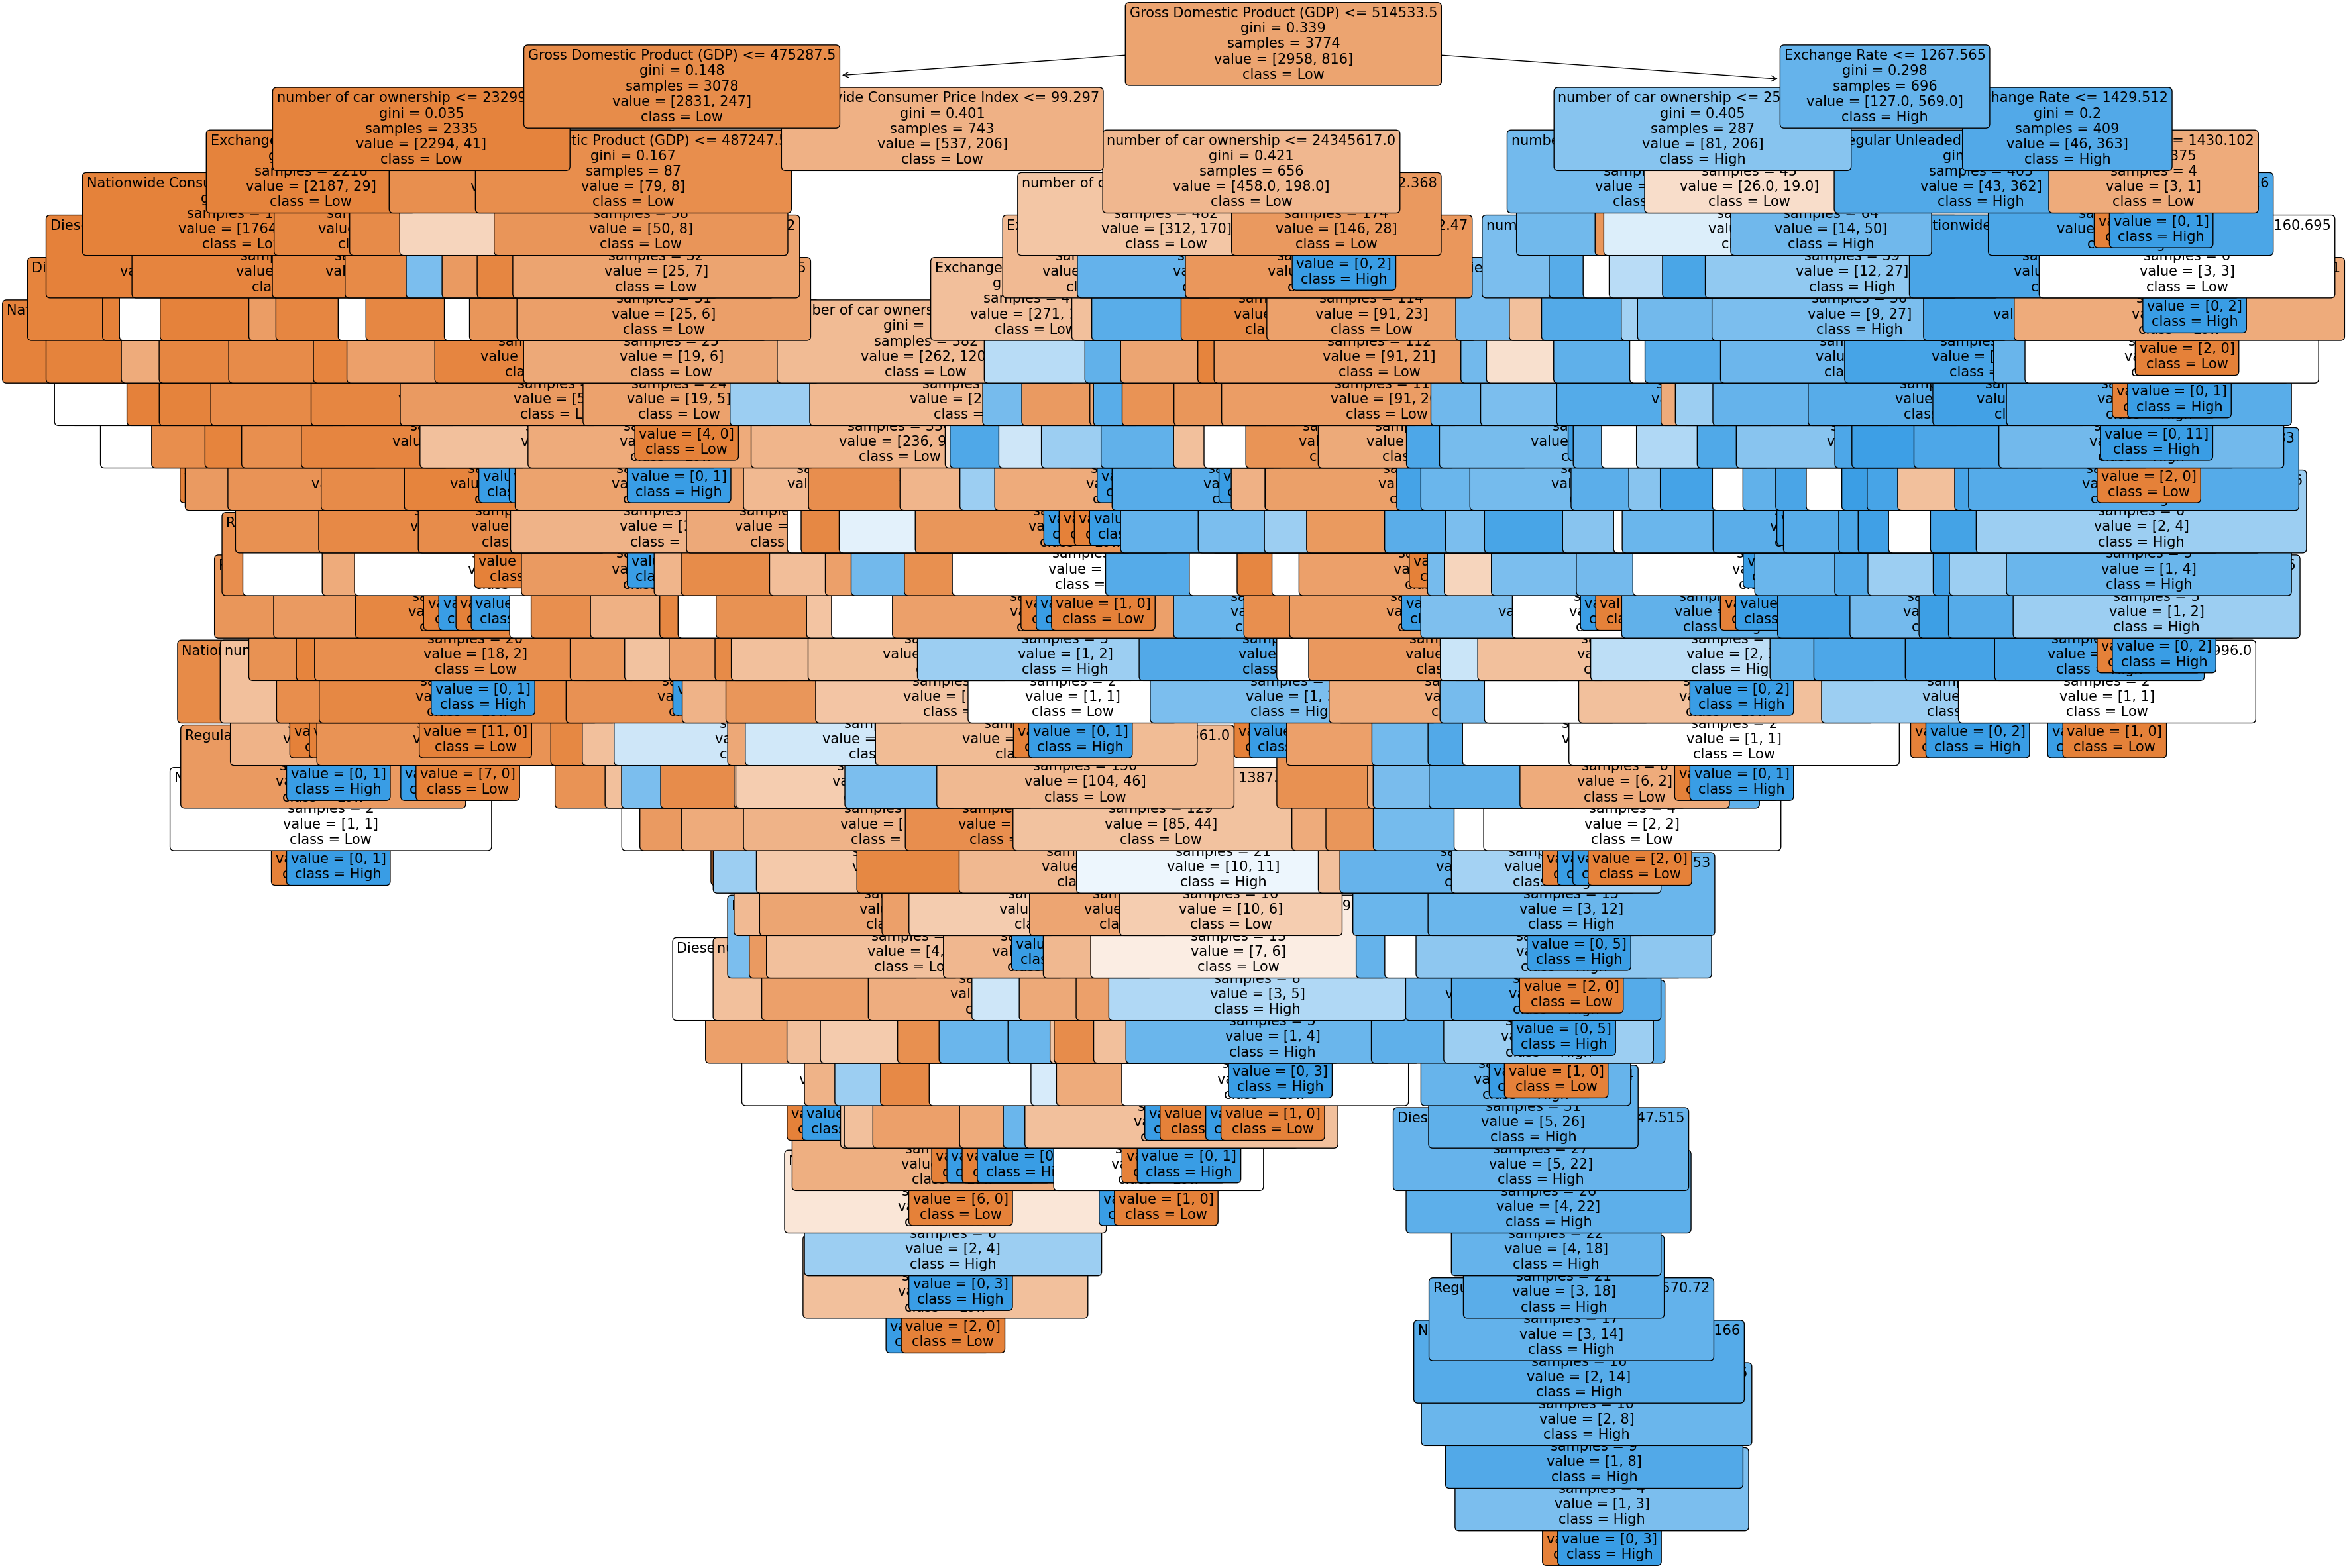

Accuracy: 0.9110169491525424


In [47]:
# Train the decision tree classifier with max depth of 5
decision_tree_classifier = DecisionTreeClassifier()
decision_tree_classifier.fit(X_train_class, y_train_class)

# Predict and evaluate
y_pred_class = decision_tree_classifier.predict(X_test_class)
accuracy_without_hyperparam_tune = accuracy_score(y_test_class, y_pred_class)

# Visualize the decision tree classifier with larger nodes
plt.figure(figsize=(40, 30))
plot_tree(decision_tree_classifier, feature_names=X_class.columns, filled=True, rounded=True, class_names=['Low', 'High'], fontsize=15)
plt.show()

print(f'Accuracy: {accuracy}')

## Hyperparameter Tuning

In [13]:
# 튜닝할 하이퍼파라미터 그리드 생성
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_classifier = DecisionTreeClassifier() # for GridSearchCV

# GridSearchCV를 사용하여 모델 훈련
grid_search = GridSearchCV(dt_classifier, param_grid, cv=5)
grid_search.fit(X_train_class, y_train_class)

# Printout Best Hyperparameter values and their scores
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score (Using Best Hyperparams):", grid_search.best_score_)


Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best Score (Using Best Hyperparams): 0.9054090326207248


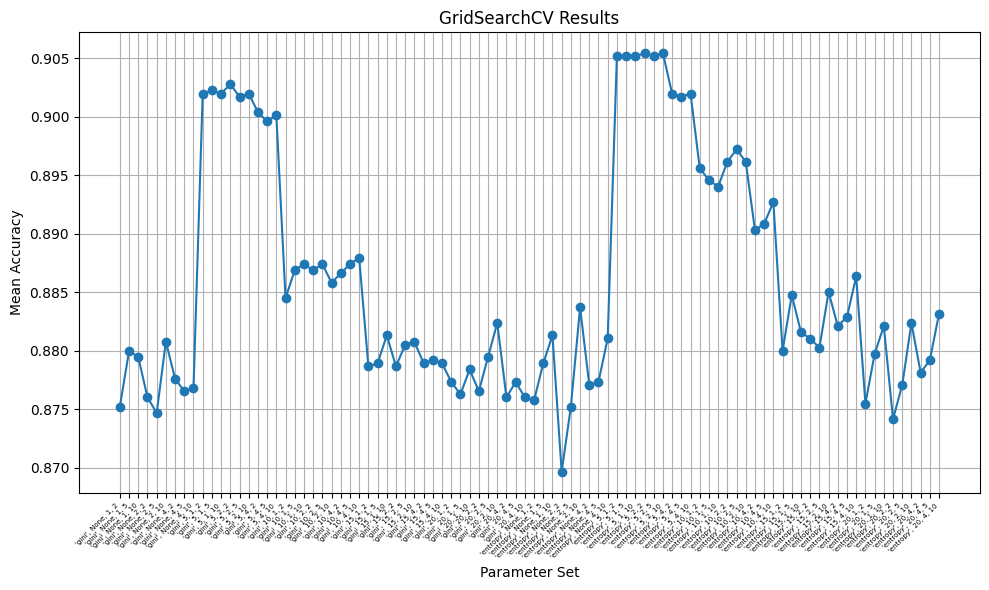

In [46]:
# Visualize result of GridSearchCV
results = grid_search.cv_results_
params = results['params']
mean_scores = results['mean_test_score']

# Visualize Scores : With Different hyperparameter values
plt.figure(figsize=(10, 6))
plt.plot(range(len(params)), mean_scores, marker='o')
plt.title('GridSearchCV Results')
plt.xlabel('Parameter Set')
plt.ylabel('Mean Accuracy')
plt.xticks(range(len(params)), [str(param.values()).replace('dict_values([','').replace('])', '') for param in params], rotation=45, fontsize=5, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

## Decision Tree Classifier - With Hyperparameter Tuning

In [52]:
# Train model with Best Hyperparameters
best_dt_classifier = grid_search.best_estimator_
best_dt_classifier.fit(X_train_class, y_train_class)

# Predict with Test Dataset
y_pred = best_dt_classifier.predict(X_test_class)

# Printout accuracy (= Best Accuracy)
accuracy_with_hyperparam_tune = accuracy_score(y_test_class, y_pred)
print("Accuracy (with tuned hyperparameters):", accuracy_with_hyperparam_tune)

Accuracy (with tuned hyperparameters): 0.9110169491525424


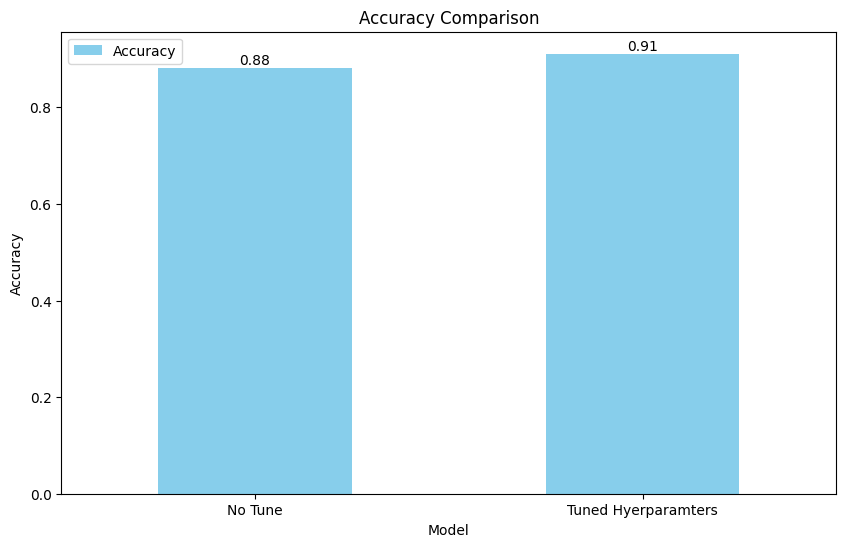

In [51]:
acc_df = pd.DataFrame({
    'Model': ['No Tune', 'Tuned Hyerparamters'],
    'Accuracy': [accuracy_without_hyperparam_tune, accuracy_with_hyperparam_tune],
})

# Get Bar graph
ax = acc_df.set_index('Model').plot(kind='bar', figsize=(10, 6), color='skyblue')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)

# Print
for i, score in enumerate(acc_df['Accuracy']):
    ax.text(i, score, f'{score:.2f}', ha='center', va='bottom')
